#### Bayesian Linear Regression with Metropolis Hastings

This notebook does linear regression with metropolis hastings from scratch to understand what is going on. We do not use any programing packages to get the parameters of the linear model. We however, will have to see how to get the posterior predictions for this model. As per Gelfand, it is fine to go with the found betas and error variance for the new observations. We follow the article at https://medium.com/@tinonucera/bayesian-linear-regression-from-scratch-a-metropolis-hastings-implementation-63526857f191. For simplicity, we are just considering a single predictor model with unknown error variance to understand what goes under the hood. 

Let Y and X be a response and a predictor for the model, respectively. The linear regression modedl is given by 

$Y|X \sim N (aX + b, \sigma^2)$

Our task is inferring $a$, $b$, and $σ$.

In this case, let’s generate synthetic data for the regression, using parameters $a=3$, $b=20$ and $σ=5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc

In [2]:
# sample x
np.random.seed(2024)
x = np.random.rand(100)*30

In [3]:
x.shape

(100,)

In [4]:
# set parameters
a = 3
b = 20
sigma = 5

In [5]:
# obtain response and add noise
y = a*x+b
noise = np.random.randn(100)*sigma
y = y + noise

In [6]:
# create a matrix containing the predictor in the first column
# and the response in the second
data = np.vstack((x,y)).T

In [7]:
noise.reshape(-1,1).shape

(100, 1)

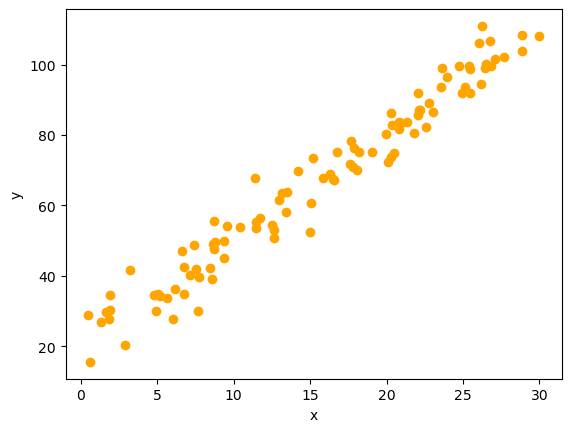

In [8]:
# plot data 
plt.scatter(data[:,0], data[:,1], color = 'orange')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Now let's move on to defining the MH part. and looping though iterations.

Let θ=[a,b,σ] be the vector of parameters at the previous step of the algorithm and θ’ be a proposal for a new set of parameters, MH compares the Bayes Factor (the product of likelihood and prior) between two competing hypotheses for the parameters (θ’ and θ) and scales this factor by the reciprocal of the conditional proposal distribution. This factor is then compared with the value of a uniformly distributed random variable. This adds stochasticity to the model and makes it possible for unlikely parameter vectors to be explored and for likely ones to be discarded (rarely).

##### Let's define the proposal distribution

First, we define a proposal distribution g(θ’|θ): this is a distribution for fixed parameters at the previous time step. In our example, a and b can be both positive and negative, therefore a natural choice would be sampling them from a multivariate normal distribution centered at the previous iteration step. As for σ, we can for example sample it from a Gamma distribution. It is really up to the user defining all these distributions.

As a result, we can define a proposal distribution in the following way:

$\begin{pmatrix}
a'\\
b'
\end{pmatrix} \sim N \begin{pmatrix} \begin{pmatrix}
a\\
b
\end{pmatrix}, \begin{pmatrix}
k^2 & 0\\
0 & k^2
\end{pmatrix}
\end{pmatrix}$
(proposal distribution for a and b)

And $\sigma' \sim gamma(\sigma kw, kw)$
(proposal distrribution for $\sigma$)

The parameter k is used to control the “spread” of the distributions around their means. 𝜔 is an extra adjustment for the Gamma. The larger k𝜔, the bigger the spread for the gamma (we are using the shape-rate formulation of the Gamma distribution, be careful as scipy forces us to use the shape-scale formulation instead). 

Define the proposal distribution function as below.

In [9]:
def proposal(prec_theta, search_width = 0.5):
    # this function generates the proposal for the new theta
    # we assume that the distribution of the random variables 
    # is normal for the first two and gamma for the third.
    # conditional on the previous value of the accepted parameters (prec_theta)
    # search width is the k parameter above
    out_theta = np.zeros(3)
    out_theta[:2] = sc.multivariate_normal(mean=prec_theta[:2],cov=np.eye(2)*search_width**2).rvs(1)
    #the last component is the noise
    out_theta[2] = sc.gamma(a=prec_theta[2]*search_width*500, scale=1/(500*search_width)).rvs()
    return out_theta

You can notice how the function proposal contains two arguments: prec_theta represents the parameter vector at the previous step and search_width represents the region where we will be looking for proposals. Looking for a good set of parameters introduces a trade-off between exploration (the search for new parameters set in unexplored areas) and exploitation (refining the search closer to the areas where good sets of parameters have been found). As a result, search_width should be handled with extreme care. A large value of search_widthwill prevent the MCMC from converging to a stationary distribution. A small value may prevent the algorithm from finding the optimum (optima) in a reasonable amount of time (more samples will need to be drawn and longer burn-in period would be expected).

##### Likelihood function

In [10]:
def lhd(x,theta):
    # x is the data matrix, first column for input and second column for output.
    # theta is a vector containing the parameters for the evaluation
    # remember theta[0] is a, theta[1] is b and theta[2] is sigma
    xs = x[:,0]
    ys = x[:,1]
    lhd_out = sc.norm.logpdf(ys, loc=theta[0]*xs+theta[1], scale=theta[2])
    # then we sum lhd_out (be careful here, we are summing instead of multiplying
    # because we are dealing with the log-likelihood, instead of the raw likelihood).
    lhd_out = np.sum(lhd_out)
    return lhd_out

##### Prioir

We do not need to spend a lot of words on this. We can really choose anything we like in term of distribution for the prior. All we need to do is to make sure that the zone where the inferred-to-be parameters are likely to be found have non-zero prior, and that the noise parameter σ is non-negative. Again, the prior is expressed in terms of a log-pdf.

In [11]:
def prior(theta):
    # evaluate the prior for the parameters on a multivariate gaussian. 
    prior_out = sc.multivariate_normal.logpdf(theta[:2],mean=np.array([0,0]), cov=np.eye(2)*100)
    # this needs to be summed to the prior for the sigma, since I assumed independence.
    prior_out += sc.gamma.logpdf(theta[2], a=1, scale=1)
    return prior_out

Proporsal ratio

The proposal ratio is the likelihood of observing the old parameter vector given the new one divided by the probability of observing the new parameter vector given the old one. That is, g(θ|θ’)/g(θ’|θ). Again, we will employ the log-pdf so as to have uniformity of scales across probabilities and to achieve better numerical stability.

In [12]:
def proposal_ratio(theta_old, theta_new, search_width=10):
    # this is the proposal distribution ratio
    # first, we calculate of the pdf of the proposal distribution at the old value of theta with respect to the new 
    # value of theta. And then we do the exact opposite.
    prop_ratio_out = sc.multivariate_normal.logpdf(theta_old[:2],mean=theta_new[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out += sc.gamma.logpdf(theta_old[2], a=theta_new[2]*search_width*500, scale=1/(500*search_width))
    prop_ratio_out -= sc.multivariate_normal.logpdf(theta_new[:2],mean=theta_old[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out -= sc.gamma.logpdf(theta_new[2], a=theta_old[2]*search_width*500, scale=1/(500*search_width))
    return prop_ratio_out

Algorithm

In [13]:
# 1) Instantiate initial values for the parameter vector

# ... N TIMES or UNTIL CONVERGENCE
# 2) Draw a new parameter vector from the proposal
# 3) Calculate likelihood, prior pdf value and the reciprocal of the proposal likelihood ratio
# 4) Multiply all the quantities in 3 (or sum if in log) and compare this ratio (in linear scale)
     # against a number drawn from a uniform distribution. 
# 5) If the ratio is larger, the new parameter vector is accepted.
     # Otherwise, the new parameter vector is rejected.
# 6) Move to 2)

In [18]:
%%time
np.random.seed(100)
width = 0.2

thetas = np.random.rand(3).reshape(1,-1)
accepted = 0
rejected = 0

N = 100000

for i in range(N):

    # 1) provide a proposal for theta
    theta_new = proposal(thetas[-1,:], search_width=width)
    
    # 2) calculate the likelihood of this proposal and the likelihood
    # for the old value of theta
    log_lik_theta_new = lhd(data,theta_new)
    log_lik_theta = lhd(data,thetas[-1,:])
    
    # 3) evaluate the prior log-pdf at the current and at the old value of theta
    theta_new_prior = prior(theta_new)
    theta_prior = prior(thetas[-1,:])
    
    # 4) finally, we need the proposal distribution ratio
    prop_ratio = proposal_ratio(thetas[-1], theta_new, search_width=width)
    
    # 5) assemble likelihood, priors and proposal distributions
    likelihood_prior_proposal_ratio = log_lik_theta_new - log_lik_theta + \
                             theta_new_prior - theta_prior + prop_ratio
    
    # 6) throw a - possibly infinitely weigthed - coin. The move for Metropolis-Hastings is
    # not deterministic. Here, we exponentiate the likelihood_prior_proposal ratio in order
    # to obtain the probability in linear scale
    if np.exp(likelihood_prior_proposal_ratio) > sc.uniform().rvs():
        thetas = np.vstack((thetas,theta_new))
        accepted += 1
    else:
        rejected += 1

<timed exec>:34: RuntimeWarning: overflow encountered in exp


CPU times: user 3min 45s, sys: 48.8 ms, total: 3min 45s
Wall time: 3min 46s


In [19]:
thetas.shape

(15958, 3)

In [20]:
# see if the shape[0] - 1 agrees with the number of accepted proposal/current likelihood ratio.
accepted

15957

plot the posterior distributions fo the parameters and observe the curves to see how they look like? We are currently not considering a burn-in period, but ideally we should.

In [21]:
a = thetas[:,0]
b = thetas[:,1]
sigma = thetas[:,2]

In [27]:
a.shape


(15958,)

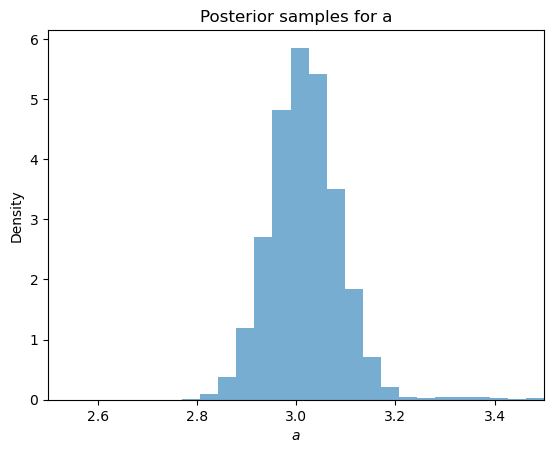

In [38]:
# Plotting the posterior distribution
plt.hist(a, density=True, bins = 100, alpha=0.6)
plt.title('Posterior samples for a')
plt.xlim(2.5, 3.5)
plt.xlabel('$a$')
plt.ylabel('Density')
plt.show()

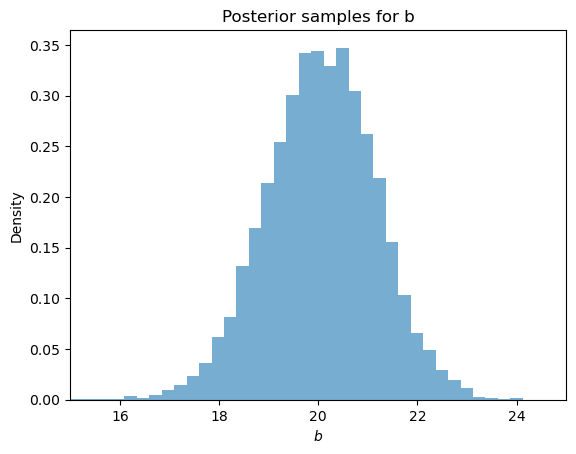

In [40]:
# Plotting the posterior distribution
plt.hist(b, density=True ,bins = 100, alpha=0.6)
plt.title('Posterior samples for b')
plt.xlim(15, 25)
plt.xlabel('$b$')
plt.ylabel('Density')
plt.show()

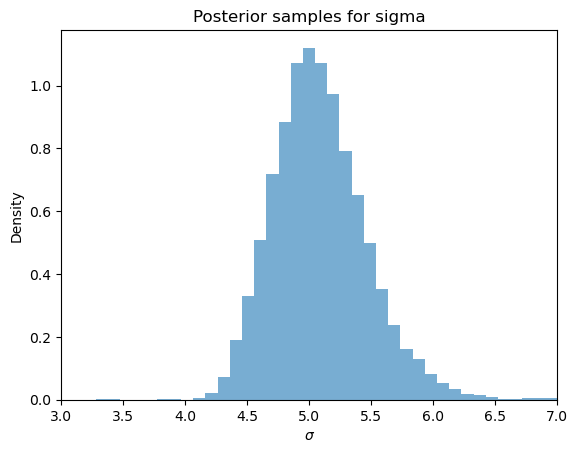

In [42]:
# Plotting the posterior distribution
plt.hist(sigma, bins=100, density=True , alpha=0.6)
plt.title('Posterior samples for sigma')
plt.xlim(3,7)
plt.xlabel('$\\sigma$')
plt.ylabel('Density')
plt.show()